### Model 1. SARIMAX 
#### Time Series Model 

__Why SARIMAX?__
* SARIMAX was chosen due to its versatility and ability to model complex time series data. This model is particularly well-suited for datasets that exhibit both non-stationarity and seasonality, which are common characteristics in retail sales data.

__By Product Category__
* EDA revealed distinct sales patterns and trends across different product categories. These patterns include varying levels of seasonality, trend, and sales volatility. By modeling each category separately, the model can capture these unique characteristics, leading to more accurate and tailored forecasts.
* Starting with SARIMAX allows for a comprehensive approach, as it can accommodate both seasonal and non-seasonal components, as well as the influence of external factors (exogenous variables). This generality ensures that the model can adapt to the specificities of each product category, from those with strong seasonal patterns to those driven more by external factors.

__Modeling Process__
* **Stationarity & Autocorrelation**: Checked for each category to tailor the SARIMAX components.
* **Parameter Optimization**: Involved selecting the best parameter combination for each category.
* **Model Diagnostics**: Conducted to ensure model adequacy.
* **Model Evaluation**: Used a 16-day forecast window to assess accuracy, with SARIMAX showing good predictive performance across different product categories.

### Import Libraries & Data

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_pickle('processed_data/train_df.pkl')
df.head(10)

,date,family,sales,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,month,year
0,2013-01-01,AUTOMOTIVE,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
1,2013-01-01,BABY CARE,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
2,2013-01-01,BEAUTY,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
3,2013-01-01,BEVERAGES,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
4,2013-01-01,BOOKS,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
5,2013-01-01,BREAD/BAKERY,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
6,2013-01-01,CELEBRATION,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
7,2013-01-01,CLEANING,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
8,2013-01-01,DAIRY,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
9,2013-01-01,DELI,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013


### Stationarity

In [4]:
# Define target varaible & exogeneous variable
target = df['sales']
exog = df['dcoilwtico']

In [5]:
df_temp = df[['date', 'family', 'sales', 'dcoilwtico']]
df_temp = df_temp.groupby(['date', 'family']).mean().reset_index()
df_temp.set_index('date', inplace = True)

In [6]:
df_temp['family'].value_counts()
df_temp.head()

,family,sales,dcoilwtico
date,,,
2013-01-01,AUTOMOTIVE,0.000000,93.14
2013-01-01,BABY CARE,0.000000,93.14
2013-01-01,BEAUTY,0.037037,93.14
2013-01-01,BEVERAGES,15.000000,93.14
2013-01-01,BOOKS,0.000000,93.14


In [7]:
df_temp[df_temp['family'] == 'BABY CARE'].head()

,family,sales,dcoilwtico
date,,,
2013-01-01,BABY CARE,0.0,93.140000
2013-01-02,BABY CARE,0.0,93.140000
2013-01-03,BABY CARE,0.0,92.970000
2013-01-04,BABY CARE,0.0,93.120000
2013-01-05,BABY CARE,0.0,93.146667


In [8]:
family = df.family.unique()

In [9]:
adf_results = {}
diff = {}

for cat in family:
    group = df_temp.loc[df_temp['family'] == cat, :]
    adf_result = adfuller(group['sales'])
    adf_results[cat] = adf_result
    print(f'ADF Statistic for {cat}: {adf_result[0]}')
    print(f'p-value for {cat}: {adf_result[1]}')

    if adf_result[1] < 0.05:
        diff[cat] = 0
    else:
        diff[cat] = 1

ADF Statistic for AUTOMOTIVE: -3.2290887443448284
p-value for AUTOMOTIVE: 0.018361456117775652
ADF Statistic for BABY CARE: -2.430880299280003
p-value for BABY CARE: 0.13320965540267538
ADF Statistic for BEAUTY: -1.7732187565486761
p-value for BEAUTY: 0.39383653785330913
ADF Statistic for BEVERAGES: -2.5291275634882755
p-value for BEVERAGES: 0.10854714867177073
ADF Statistic for BOOKS: -3.228409613891024
p-value for BOOKS: 0.01839799905425337
ADF Statistic for BREAD/BAKERY: -1.923615724753931
p-value for BREAD/BAKERY: 0.3210343720141503
ADF Statistic for CELEBRATION: -2.874515116868649
p-value for CELEBRATION: 0.04839281773091838
ADF Statistic for CLEANING: -3.3810400408029873
p-value for CLEANING: 0.011622448264867843
ADF Statistic for DAIRY: -1.9964505663190777
p-value for DAIRY: 0.2881315675218752
ADF Statistic for DELI: -2.3979546613843583
p-value for DELI: 0.1423145227744546
ADF Statistic for EGGS: -2.3444003758293186
p-value for EGGS: 0.1580474044876093
ADF Statistic for FROZEN F

In [14]:
print("Categories with p-value < 0.05 (likely stationary):")
print(diff)

Categories with p-value < 0.05 (likely stationary):
{'AUTOMOTIVE': 0, 'BABY CARE': 1, 'BEAUTY': 1, 'BEVERAGES': 1, 'BOOKS': 0, 'BREAD/BAKERY': 1, 'CELEBRATION': 0, 'CLEANING': 0, 'DAIRY': 1, 'DELI': 1, 'EGGS': 1, 'FROZEN FOODS': 0, 'GROCERY I': 0, 'GROCERY II': 0, 'HARDWARE': 0, 'HOME AND KITCHEN I': 0, 'HOME AND KITCHEN II': 1, 'HOME APPLIANCES': 0, 'HOME CARE': 1, 'LADIESWEAR': 0, 'LAWN AND GARDEN': 1, 'LINGERIE': 0, 'LIQUOR,WINE,BEER': 0, 'MAGAZINES': 1, 'MEATS': 0, 'PERSONAL CARE': 0, 'PET SUPPLIES': 1, 'PLAYERS AND ELECTRONICS': 0, 'POULTRY': 1, 'PREPARED FOODS': 1, 'PRODUCE': 0, 'SCHOOL AND OFFICE SUPPLIES': 0, 'SEAFOOD': 0}


### Autocorrelation

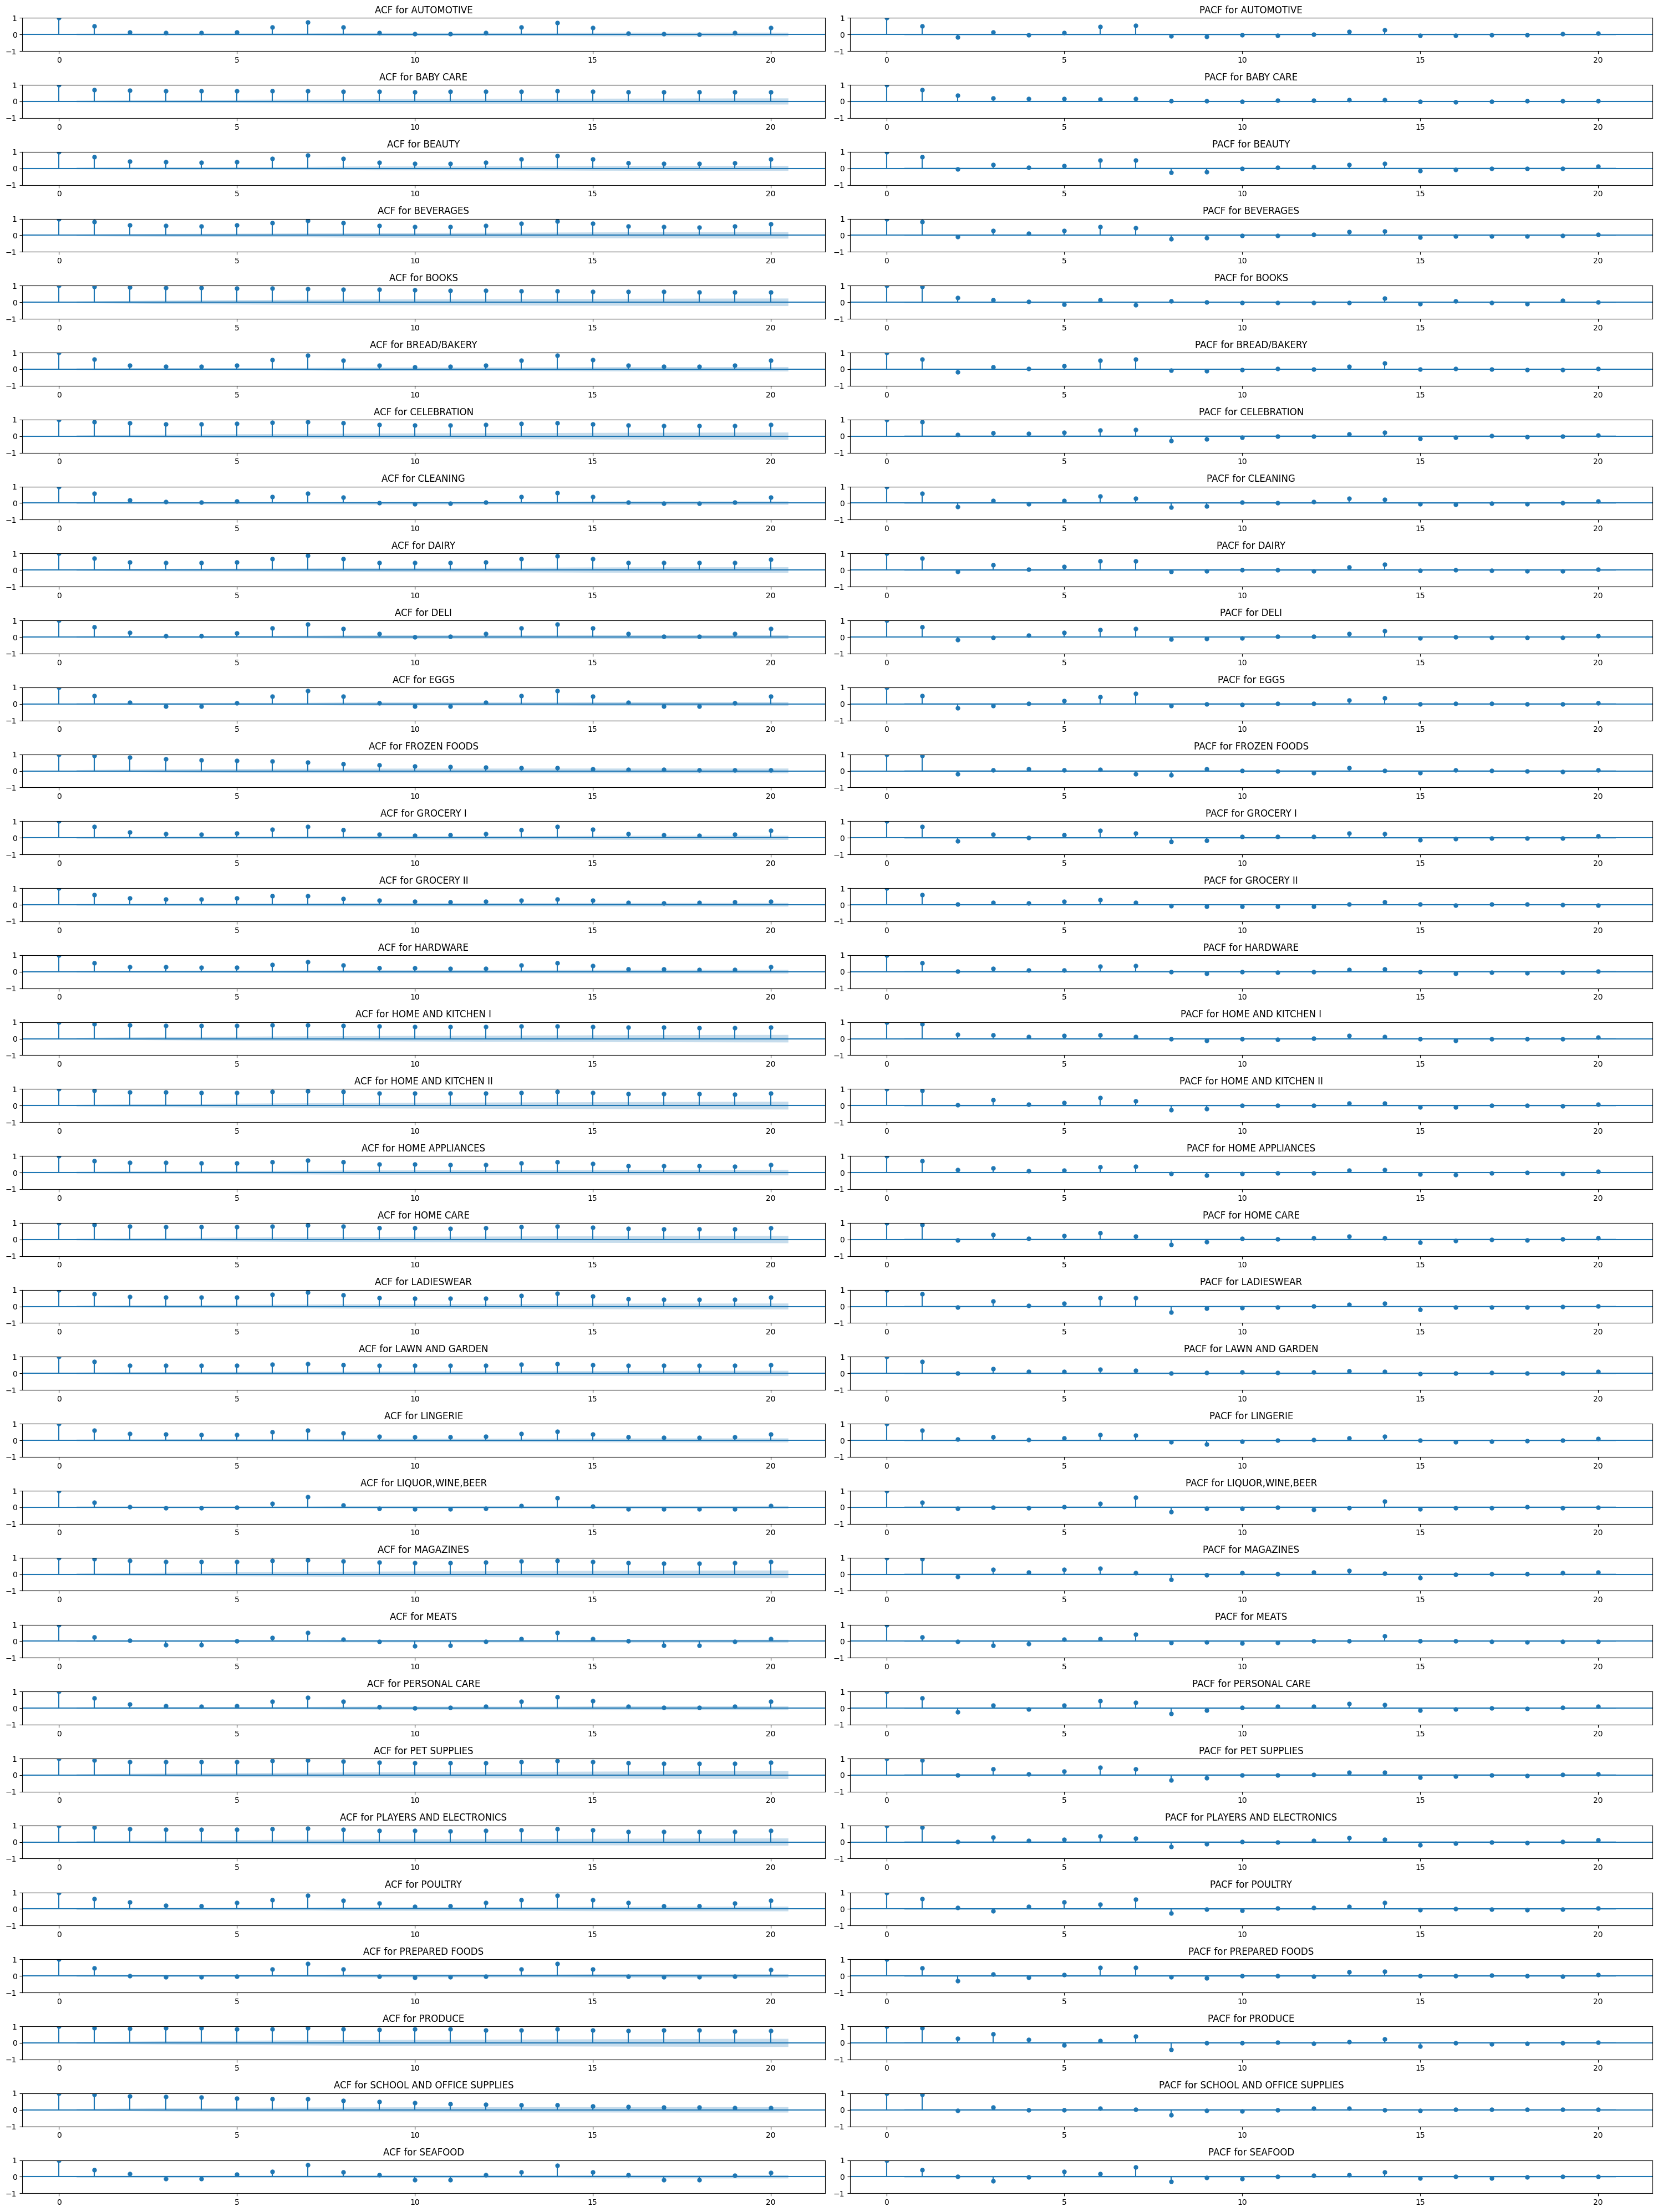

In [15]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

# Determine the number of rows/columns for the subplot grid
num_categories = 33
cols = 2  # Two columns: one for ACF and one for PACF
rows = math.ceil(num_categories / (cols / 2))  # Divide by 2 as each category takes two columns

# Create subplots with adjusted figure size
fig, axes = plt.subplots(rows, cols, figsize=(30, 40))  # Adjust figure size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, cat in enumerate(family):
    group = df_temp.loc[df_temp['family'] == cat, :]
    sales = group['sales']

    # Create ACF plot for each category
    plot_acf(sales, ax=axes[i * 2], lags=20, alpha=0.05)  # Adjust lags as needed
    axes[i * 2].set_title(f'ACF for {cat}')

    # Create PACF plot for each category
    plot_pacf(sales, ax=axes[i * 2 + 1], lags=20, alpha=0.05)  # Adjust lags as needed
    axes[i * 2 + 1].set_title(f'PACF for {cat}')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


### Optimize SARIMAX

In [16]:
def optimize_SARIMAX(endog: Union[pd.Series, list], 
                     order_list: list, 
                     d: int, 
                     D: int, 
                     s: int, 
                     exog: Union[pd.Series, list, None] = None) -> pd.DataFrame:
    
    results = []
    
    for order in order_list:
        try:
            # Include exog in the model only if it is not None
            if exog is not None:
                model = SARIMAX(endog,
                                exog=exog,
                                order=(order[0], d, order[1]),
                                seasonal_order=(order[2], D, order[3], s),
                                simple_differencing=False).fit(disp=False)
            else:
                model = SARIMAX(endog,
                                order=(order[0], d, order[1]),
                                seasonal_order=(order[2], D, order[3], s),
                                simple_differencing=False).fit(disp=False)
        except Exception as e:
            print(f"An error occurred: {e}")
            continue

        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
# define parameter space
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 52 

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
# optimization for each product category
best_models = {}
for cat in family:
    print('Optimizing SARMIAX for ...', cat)
    group = df_temp.loc[df_temp['family'] == cat, :]
    target_train = group['sales']
    result = optimize_SARIMAX(target_train, parameters_list, diff[cat], D, s)
    best_models[cat] = result.loc[0, '(p,q,P,Q)']

In [19]:
best_models = {'AUTOMOTIVE': (0, 3, 3, 3),
 'BABY CARE': (2, 1, 0, 0),
 'BEAUTY': (2, 3, 3, 2),
 'BEVERAGES': (3, 3, 2, 3),
 'BOOKS': (2, 3, 1, 0),
 'BREAD/BAKERY': (2, 3, 2, 3),
 'CELEBRATION': (3, 3, 2, 3),
 'CLEANING': (0, 1, 3, 0),
 'DAIRY': (2, 3, 3, 3),
 'DELI': (3, 3, 3, 3),
 'EGGS': (3, 3, 2, 2),
 'FROZEN FOODS': (0, 3, 2, 1),
 'GROCERY I': (0, 3, 3, 3),
 'GROCERY II': (3, 3, 2, 1),
 'HARDWARE': (0, 0, 3, 3),
 'HOME AND KITCHEN I': (1, 3, 3, 3),
 'HOME AND KITCHEN II': (3, 3, 3, 3),
 'HOME APPLIANCES': (3, 1, 3, 3),
 'HOME CARE': (3, 3, 2, 3),
 'LADIESWEAR': (0, 0, 3, 3),
 'LAWN AND GARDEN': (2, 1, 3, 3),
 'LINGERIE': (3, 2, 3, 3),
 'LIQUOR,WINE,BEER': (1, 0, 2, 3),
 'MAGAZINES': (2, 3, 2, 3),
 'MEATS': (0, 2, 2, 0),
 'PERSONAL CARE': (0, 3, 2, 1),
 'PET SUPPLIES': (2, 3, 2, 3),
 'PLAYERS AND ELECTRONICS': (3, 3, 3, 1),
 'POULTRY': (3, 3, 0, 3),
 'PREPARED FOODS': (2, 3, 2, 3),
 'PRODUCE': (0, 1, 3, 1),
 'SCHOOL AND OFFICE SUPPLIES': (3, 2, 0, 3),
 'SEAFOOD': (3, 0, 2, 1)}

In [20]:
best_params = {}
best_params = {key: (best_models[key], diff[key], D) for key in best_models}
best_params

{'AUTOMOTIVE': ((0, 3, 3, 3), 0, 0),
 'BABY CARE': ((2, 1, 0, 0), 1, 0),
 'BEAUTY': ((2, 3, 3, 2), 1, 0),
 'BEVERAGES': ((3, 3, 2, 3), 1, 0),
 'BOOKS': ((2, 3, 1, 0), 0, 0),
 'BREAD/BAKERY': ((2, 3, 2, 3), 1, 0),
 'CELEBRATION': ((3, 3, 2, 3), 0, 0),
 'CLEANING': ((0, 1, 3, 0), 0, 0),
 'DAIRY': ((2, 3, 3, 3), 1, 0),
 'DELI': ((3, 3, 3, 3), 1, 0),
 'EGGS': ((3, 3, 2, 2), 1, 0),
 'FROZEN FOODS': ((0, 3, 2, 1), 0, 0),
 'GROCERY I': ((0, 3, 3, 3), 0, 0),
 'GROCERY II': ((3, 3, 2, 1), 0, 0),
 'HARDWARE': ((0, 0, 3, 3), 0, 0),
 'HOME AND KITCHEN I': ((1, 3, 3, 3), 0, 0),
 'HOME AND KITCHEN II': ((3, 3, 3, 3), 1, 0),
 'HOME APPLIANCES': ((3, 1, 3, 3), 0, 0),
 'HOME CARE': ((3, 3, 2, 3), 1, 0),
 'LADIESWEAR': ((0, 0, 3, 3), 0, 0),
 'LAWN AND GARDEN': ((2, 1, 3, 3), 1, 0),
 'LINGERIE': ((3, 2, 3, 3), 0, 0),
 'LIQUOR,WINE,BEER': ((1, 0, 2, 3), 0, 0),
 'MAGAZINES': ((2, 3, 2, 3), 1, 0),
 'MEATS': ((0, 2, 2, 0), 0, 0),
 'PERSONAL CARE': ((0, 3, 2, 1), 0, 0),
 'PET SUPPLIES': ((2, 3, 2, 3), 1, 0),


### Model Diagnostics

In [18]:
for cat in family:
    print('Results for: ', cat)
    group = df_temp.loc[df_temp['family'] == cat, :]
    target_train = group['sales']
    best_model = SARIMAX(target_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
    best_model_fit = best_model.fit(disp=False)
    print(best_model_fit.summary())

Optimizing SARMIAX for ... AUTOMOTIVE
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1684
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -3033.921
Date:                Thu, 04 Jan 2024   AIC                           6081.842
Time:                        12:58:43   BIC                           6119.840
Sample:                             0   HQIC                          6095.916
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0183      0.021     -0.877      0.380      -0.059       0.023
ar.L2         -0.7917      0.009    -87.069      0.000      -0.810      -0.774
ar.L3         

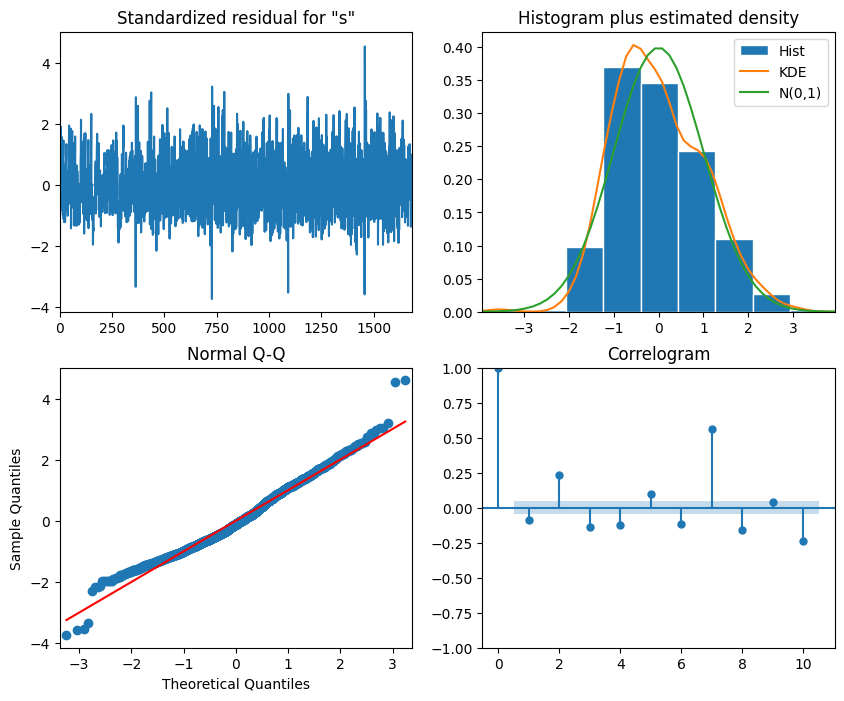

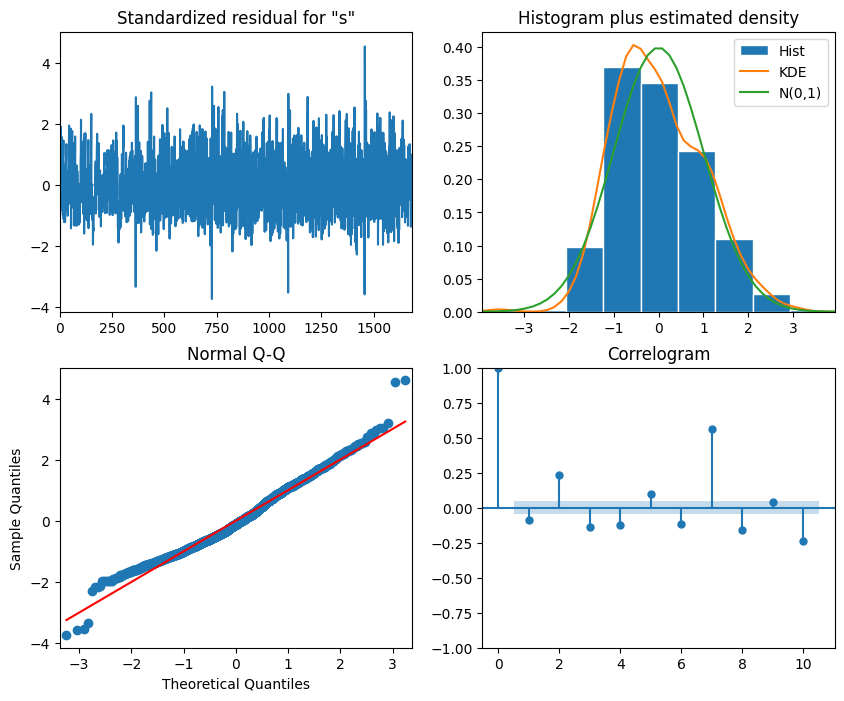

In [19]:
best_model_fit.plot_diagnostics(figsize=(10,8))

### Recurring Forecasts 

In [21]:
def recursive_forecast(endog: Union[pd.Series, list], 
                       exog: Union[pd.Series, list], 
                       order_list,
                       d,
                       D,
                       train_len: int, 
                       horizon: int, 
                       window: int, 
                       method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(order_list[0],d,order_list[1]), 
                            seasonal_order=(order_list[2],D,order_list[3],12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [ ]:
from joblib import Parallel, delayed

df = df_temp
train_end_date = '2017-06-30'
val_start_date = '2017-07-01'
val_end_date = '2017-08-15'

# Function to process each category
def process_category(cat, df, best_params):
    print(cat)

    # Filter data for the current category
    category_data = df[df['family'] == cat]
    target = category_data['sales']
    exog = category_data['dcoilwtico']

    # Correctly slicing train and validation data
    train_data = category_data[:train_end_date]
    validation_data = category_data[val_start_date:val_end_date]
    
    target_train = target.loc[train_data.index]
    target_test = target.loc[validation_data.index]

    pred_df = pd.DataFrame({'actual': target_test, 'family': cat})

    TRAIN_LEN = len(target_train)
    HORIZON = len(target_test)
    WINDOW = 1

    # Get the best parameters for this category
    order_list, d, D = best_params[cat]

    pred_last_value = recursive_forecast(target, exog, order_list, d, D, TRAIN_LEN, HORIZON, WINDOW, 'last')
    pred_SARIMAX = recursive_forecast(target, exog, order_list, d, D, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

    pred_df['pred_last_value'] = pred_last_value
    pred_df['pred_SARIMAX'] = pred_SARIMAX

    return pred_df

# Parallel processing over categories
families = df['family'].unique()  # Assuming 'family' is a column in your DataFrame
results = Parallel(n_jobs=-1)(delayed(process_category)(cat, df, best_params) for cat in families)

# Efficient concatenation after processing
pred_dfs = pd.concat(results)

In [ ]:
# weighted forecasting for each store 1-54

# Calculate the total historical sales for each store to use as weights
store_weights = df.groupby('store_nbr')['sales'].sum()

# Normalize the weights so they sum up to 1 
store_weights = store_weights / store_weights.sum()

# Adjust the forecasts by these weights
pred_df['weighted_forecast'] = pred_df.apply(
    lambda row: row['forecast'] * store_weights[row['store_nbr']], axis=1
)

### Model Evaluations

In [ ]:
# mape - Mean Absolute Percentage Error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)
mape_weighted_SARIMAX = mape(pred_df.actual, pred_df.weighted_forecast)

print(mape_last, mape_SARIMAX, mape_weighted_SARIMAX)

In [ ]:
# rmsle - Root Mean Squared Logarithmic Error

def rmsle(y_true, y_pred):

    sum = 0.0
    for actual, predicted in zip(y_true, y_pred):
        # Avoid negative predictions
        predicted = max(0, predicted)
        
        # Calculate the logarithmic difference and square it
        log_diff = math.log1p(predicted) - math.log1p(actual)
        sum += log_diff * log_diff

    mean_squared_log_error = sum / len(y_true)
    return math.sqrt(mean_squared_log_error)

In [ ]:
rmlse_last = rmsle(pred_df.actual, pred_df.pred_last_value)
rmlse_SARIMAX = rmsle(pred_df.actual, pred_df.pred_SARIMAX)
rmlse_weighted_SARIMAX = rmsle(pred_df.actual, pred_df.weighted_forecast)

print(rmlse_last, rmlse_SARIMAX, rmlse_weighted_SARIMAX)